# Project TC5 - Image denoising in wavelet domain

Name: Jingzhuo HUI, You ZUO

Date: 07/01/2021

In [1]:
import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt

from nt_toolbox.general import *
from nt_toolbox.signal import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Simulation of inpainting problem

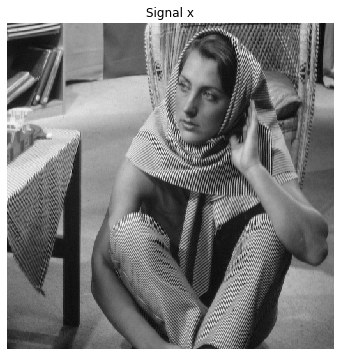

In [2]:
# display of original Image
name = 'nt_toolbox/data/barb.bmp'
x = load_image(name)

plt.figure(figsize = (6,6))
imageplot(x, 'Signal x')

Then we a generate a random binary matrix A of the same size of the image, with a parameter $p$ controling the bernoulli law

In [3]:
from numpy import random

# Amount of removed pixels/ the parameter of Bernoulli for matrix A
p = .7

# generate A
n = len(x)
A = np.zeros([n, n])
# A = np.asmatrix(A)
sel = random.permutation(n**2)
np.ravel(A)[sel[np.arange(int(p*n**2))]] = 1

Generate the Gaussian noise $b$:

In [4]:
b = np.random.normal(0,0.03,size=[n,n])

Finally we have our observation signal $y$

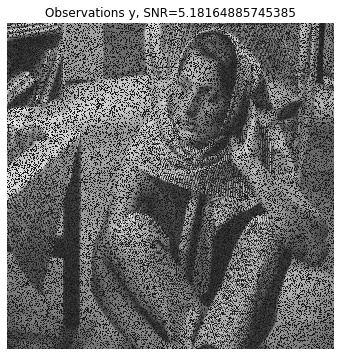

In [5]:
y = A * x + b

# Display the observations
plt.figure(figsize = (6,6))
imageplot(y, 'Observations y, SNR=' + str(snr(x,y)))

## Inpainting using Orthogonal Wavelet Sparsity

### various wavelet orhtogonal transform 

In [6]:
from nt_toolbox.perform_wavelet_transf import *
from numpy import linalg as LA

# set the parameters of the wavelet transform
Jmax = np.log2(n)-1
Jmin = (Jmax-3)

# Shortcut for wavelet basis Ψ and its adjoint matrix Ψ∗ in the orthogonal case
Psi = lambda a: perform_wavelet_transf(a, Jmin, -1, ti=0)
PsiS = lambda f: perform_wavelet_transf(f, Jmin, +1, ti=0)

# thresholding functions
SoftThresh = lambda x, T: x*np.maximum(1-T/np.maximum(abs(x), 1e-10*np.ones(np.shape(x))), np.zeros(np.shape(x)))

HardThresh = lambda x, T: x*(abs(x) > T)

Wiener = lambda x, T: x * np.maximum(0, 1 - T**2 / np.square(x))

In [7]:
def fista(A,y,lambd,threshold,maxit=300,tol=1e-3):
    niter = maxit
    n = A.shape[0]
    A = np.matrix.flatten(A)
    y = np.matrix.flatten(y)

    # Initialization 
    xinv = np.zeros(A.shape[0])
    zinv = xinv.copy()
    L = 1
    T = lambd/L
    t = 0

    for iiter in range(maxit):
        xinv_old = xinv.copy()

        # compute residual
        resz = y - A * zinv

        # compute gradient
        grad = (np.transpose(A) * resz) / L

        # update inverted model
        xinv_unthesh = zinv + grad 
        xinv = Psi(threshold(PsiS(xinv_unthesh.reshape((n,n))), T))
        xinv = np.matrix.flatten(xinv)


        # update auxiliary coefficients 
        t_old = t 
        zinv = xinv + (t_old / (t_old + 5)) * (xinv - xinv_old)
        t += 1 

        # model update        
        a_update = np.linalg.norm(xinv - xinv_old)

        # check convergence
        if a_update < tol:
            niter = iiter
            break

    return xinv.reshape((n, n)),niter

#### Soft Thresholding

In [8]:
# set up values for the threshold
LAMBDA = 0.1
x_hat, niter = fista(A,y,LAMBDA,SoftThresh)

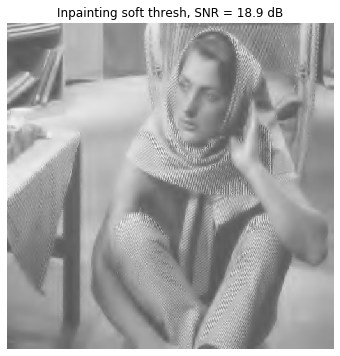

In [9]:
plt.figure(figsize = (6,6))
imageplot(x_hat, "Inpainting soft thresh, SNR = %.1f dB" %snr(x, x_hat))

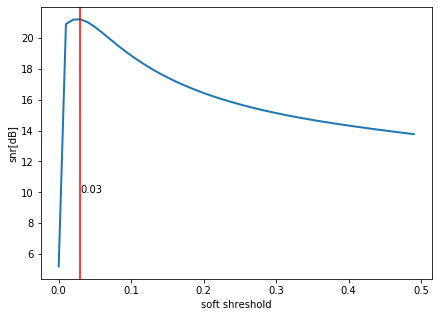

In [10]:
fSpars = y
snrs_soft = []
xhat_soft = []
LAMBDAS = np.arange(0.0,0.5,0.01)
for lambd in LAMBDAS:
    x_hat, niter = fista(A,fSpars,lambd,SoftThresh)
    xhat_soft.append(x_hat)
    snrs_soft.append(snr(x,x_hat))

plt.figure(figsize=(7,5))
plt.plot(LAMBDAS, snrs_soft, linewidth=2)
best_lambda = LAMBDAS[snrs_soft.index(max(snrs_soft))]
plt.axvline(x=best_lambda,ls="-",c="red")
plt.text(best_lambda, 10, best_lambda)

plt.xlabel("soft shreshold")
plt.ylabel("snr[dB]")
plt.show()

#### Hard Thresholding

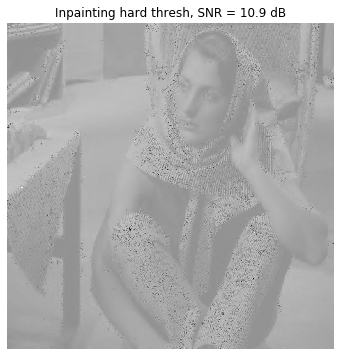

In [11]:
# set up values for the threshold
LAMBDA = 0.1
x_hat, niter = fista(A,y,LAMBDA,HardThresh)

plt.figure(figsize = (6,6))
imageplot(x_hat, "Inpainting hard thresh, SNR = %.1f dB" %snr(x, x_hat))

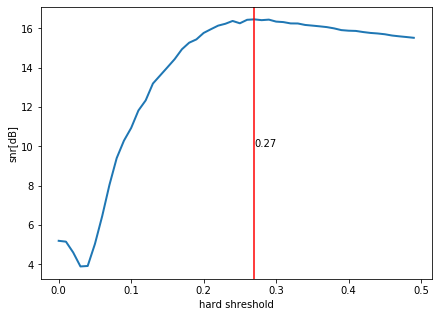

In [12]:
fSpars = y
snrs_hard = []
xhat_hard = []
LAMBDAS = np.arange(0.0,0.5,0.01)
for lambd in LAMBDAS:
    x_hat, niter = fista(A,fSpars,lambd,HardThresh)
    xhat_hard.append(x_hat)
    snrs_hard.append(snr(x,x_hat))

plt.figure(figsize=(7,5))
plt.plot(LAMBDAS, snrs_hard, linewidth=2)
best_lambda = LAMBDAS[snrs_hard.index(max(snrs_hard))]
plt.axvline(x=best_lambda,ls="-",c="red")
plt.text(best_lambda, 10, best_lambda)

plt.xlabel("hard shreshold")
plt.ylabel("snr[dB]")
plt.show()

#### Empirical Wiener

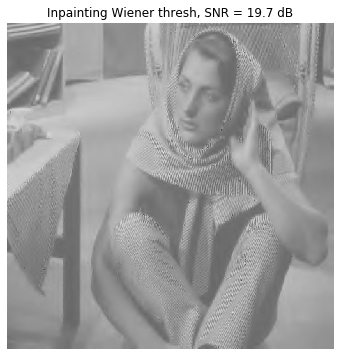

In [13]:
# set up values for the threshold
LAMBDA = 0.1
x_hat, niter = fista(A,y,LAMBDA,Wiener)

plt.figure(figsize = (6,6))
imageplot(x_hat, "Inpainting Wiener thresh, SNR = %.1f dB" %snr(x, x_hat))

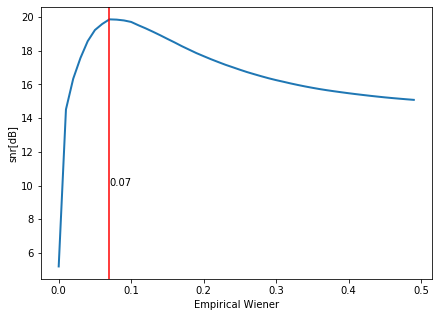

In [14]:
fSpars = y
snrs_wiener = []
xhat_wiener = []
LAMBDAS = np.arange(0.0,0.5,0.01)
for lambd in LAMBDAS:
    x_hat, niter = fista(A,fSpars,lambd,Wiener)
    xhat_wiener.append(x_hat)
    snrs_wiener.append(snr(x,x_hat))

plt.figure(figsize=(7,5))
plt.plot(LAMBDAS, snrs_wiener, linewidth=2)
best_lambda = LAMBDAS[snrs_wiener.index(max(snrs_wiener))]
plt.axvline(x=best_lambda,ls="-",c="red")
plt.text(best_lambda, 10, best_lambda)

plt.xlabel("Empirical Wiener")
plt.ylabel("snr[dB]")
plt.show()

## Inpainting using Translation Invariant Wavelet Sparsity

In [15]:
# Compute the scaling factor (inverse of the redundancy)
J = Jmax-Jmin + 1
u = np.hstack(([4**(-J)], 4**(-np.floor(np.arange(J + 2./3,1,-1./3)))))
U = np.transpose(np.tile(u, (n,n,1)),(2,0,1))

tau = 1.9*np.min(u)

In [16]:
# Shortcut for the wavelet transform and the reconstruction
Xi = lambda a: perform_wavelet_transf(a, Jmin, -1, ti=1)
PsiS = lambda f: perform_wavelet_transf(f, Jmin, + 1, ti=1)
Psi = lambda a: Xi(a/U)

SoftThreshPsi = lambda f, T: Psi(SoftThresh(PsiS(f), T))
ProjC = lambda f, Omega: Omega*y + (1-Omega)*f

In [17]:
def fista2(A,y,lambd,threshold,tau=tau,maxit=200,tol=1e-2):
    niter = maxit
    n = A.shape[0]

    # initialize 
    a = U * PsiS(y)
    
    for iiter in range(maxit):
        # gradient descent 
        a_old = a
        fTI = Psi(a_old)
        a = a_old + tau * PsiS(A * (y- A * fTI))

        # threshold
        a = SoftThresh(a, lambd * tau)
       
        a_update = np.linalg.norm(a - a_old)

        # check convergence
        if a_update < tol:
            niter = iiter
            break

    return Psi(a)

#### Soft Thresholding

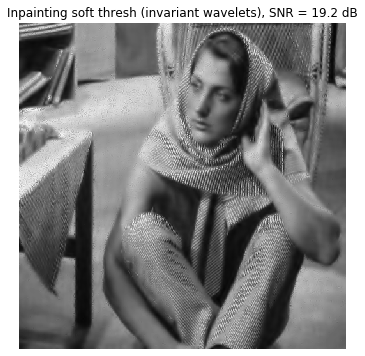

In [18]:
# set up values for the threshold
LAMBDA = 0.1
x_hat = fista2(A,y,LAMBDA,SoftThresh)

plt.figure(figsize=(6,6))
imageplot(x_hat, "Inpainting soft thresh (invariant wavelets), SNR = %.1f dB" %snr(x, x_hat))

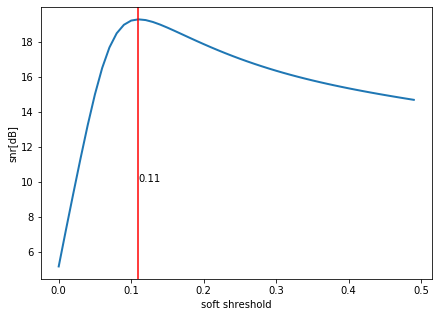

In [19]:
fSpars = y
snrs_softiv = []
xhat_softiv = []
LAMBDAS = np.arange(0.0,0.5,0.01)
for lambd in LAMBDAS:
    x_hat = fista2(A,fSpars,lambd,SoftThresh)
    xhat_softiv.append(x_hat)
    snrs_softiv.append(snr(x,x_hat))

plt.figure(figsize=(7,5))
plt.plot(LAMBDAS, snrs_softiv, linewidth=2)
best_lambda = LAMBDAS[snrs_softiv.index(max(snrs_softiv))]
plt.axvline(x=best_lambda,ls="-",c="red")
plt.text(best_lambda, 10, best_lambda)

plt.xlabel("soft shreshold")
plt.ylabel("snr[dB]")
plt.show()

#### Hard Thresholding

In [20]:
def fista3(A,y,lambd,threshold,maxit=200,tol=1e-2):
    niter = maxit
    n = A.shape[0]

    # initialization
    fHard= y.copy()
        
    for iiter in range(maxit):
        fHard_old = fHard.copy()
        fHard = Xi(HardThresh(PsiS(ProjC(fHard_old, A)), lambd))

        f_update = np.linalg.norm(fHard - fHard_old)

        # check convergence
        if f_update < tol:
            niter = iiter
            break

    return fHard

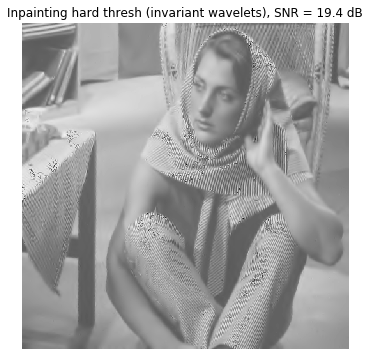

In [21]:
# set up values for the threshold
LAMBDA = 0.1
x_hat = fista3(A,y,LAMBDA,HardThresh)

plt.figure(figsize=(6,6))
imageplot(x_hat, "Inpainting hard thresh (invariant wavelets), SNR = %.1f dB" %snr(x, x_hat))

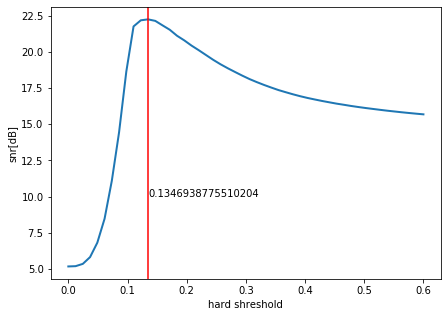

In [22]:
snrs_hardiv = []
xhat_hardiv = []

lambda_list = np.linspace(0.0, 0.6, 50)

for lambd in lambda_list:
    x_hat = fista3(A,y,lambd,HardThresh)
    xhat_hardiv.append(x_hat)
    snrs_hardiv.append(snr(x,x_hat))

plt.figure(figsize=(7,5))
plt.plot(lambda_list, snrs_hardiv, linewidth=2)
best_lambda = lambda_list[snrs_hardiv.index(max(snrs_hardiv))]
plt.axvline(x=best_lambda,ls="-",c="red")
plt.text(best_lambda, 10, best_lambda)

plt.xlabel("hard shreshold")
plt.ylabel("snr[dB]")
plt.show()

### Influences of $p$ and level of noise

In this part, we want to explore the influences of p and the noise level. we will test it on invarious wavelet orhtogonal transforms with only the soft thresholding.

In [23]:
def generate_inpainting(image,p,noise_level):
    # generate A
    n = len(image)
    A = np.zeros([n, n])
    sel = random.permutation(n**2)
    np.ravel(A)[sel[np.arange(int(p*n**2))]] = 1

    # add gaussian noise
    b = np.random.normal(0,noise_level,size=[n,n])
    y = A * x + b

    return A, y

First we want to set different values for p:

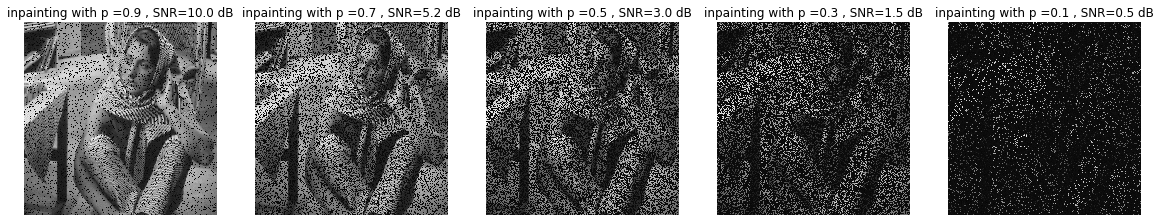

In [24]:
ps = [0.9, 0.7, 0.5, 0.3, 0.1]
As = []
ys = []

for p in ps:
    A,y = generate_inpainting(x,p=p,noise_level =0.01)
    As.append(A)
    ys.append(y)

# Display the observations
plt.figure(figsize=(20,5))
for i in range(len(ps)):
    imageplot(ys[i], 'inpainting with p =%.1f , SNR=%.1f dB' %(ps[i],snr(x,ys[i])),(1,len(ps),i+1))

In [25]:
lambda_list = np.linspace(0.0, 1, 20)
snrs_softps = [[]] * len(ps)
xhat_softps = [[]] * len(ps)

for i in range(len(ps)):
    snrs_softp = []
    xhat_softp = []

    for lambd in lambda_list:
        x_hat = fista2(As[i],ys[i],lambd,SoftThresh)
        xhat_softp.append(x_hat)
        snrs_softp.append(snr(x,x_hat))

    snrs_softps[i] = snrs_softp
    xhat_softps[i] = xhat_softp

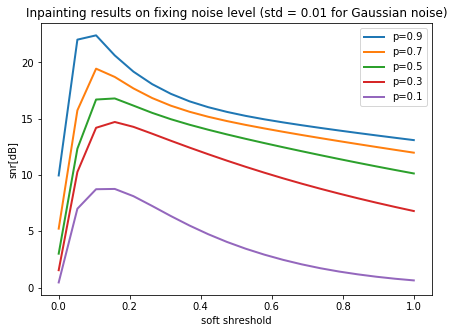

In [26]:
plt.figure(figsize=(7,5))

for i in range(len(ps)):
    plt.plot(lambda_list, snrs_softps[i], linewidth=2, label = 'p='+str(ps[i]))

plt.legend()
plt.xlabel("soft shreshold")
plt.ylabel("snr[dB]")
plt.title("Inpainting results on fixing noise level (std = 0.01 for Gaussian noise)")
plt.show()

In the nest part, we will explore the influence of added noise level by fixing the value of p equals to 0.9

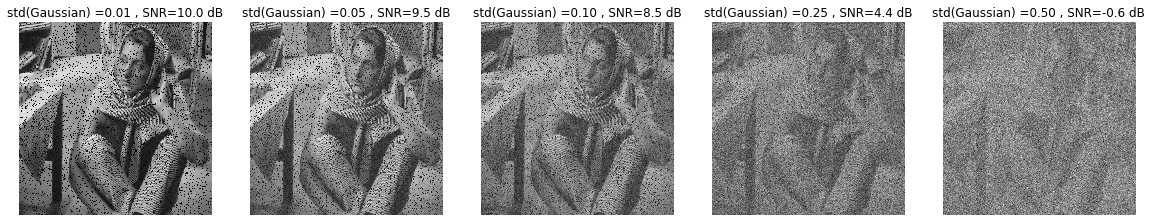

In [31]:
stds = [0.01, 0.05, 0.1, 0.25, 0.5]
As = []
ys = []

for std in stds:
    A,y = generate_inpainting(x,p=0.9,noise_level = std)
    As.append(A)
    ys.append(y)


# Display the observations
plt.figure(figsize=(20,5))
for i in range(len(stds)):
    imageplot(ys[i], 'std(Gaussian) =%.2f , SNR=%.1f dB' %(stds[i],snr(x,ys[i])),(1,len(stds),i+1))

In [32]:
lambda_list = np.linspace(0.0, 1, 20)
snrs_soft_stds = [[]] * len(stds)
xhat_soft_stds = [[]] * len(stds)

for i in range(len(stds)):
    snrs_soft_std = []
    xhat_soft_std = []

    for lambd in lambda_list:
        x_hat = fista2(As[i],ys[i],lambd,SoftThresh)
        xhat_soft_std.append(x_hat)
        snrs_soft_std.append(snr(x,x_hat))

    snrs_soft_stds[i] = snrs_soft_std
    xhat_soft_stds[i] = xhat_soft_std

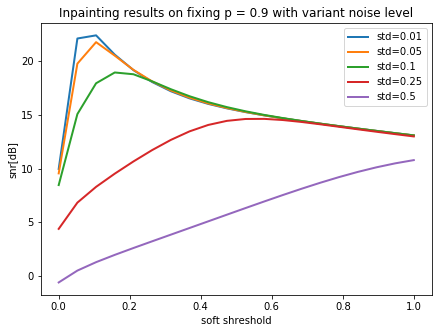

In [33]:
plt.figure(figsize=(7,5))

for i in range(len(stds)):
    plt.plot(lambda_list, snrs_soft_stds[i], linewidth=2, label = 'std='+str(stds[i]))

plt.legend()
plt.xlabel("soft shreshold")
plt.ylabel("snr[dB]")
plt.title("Inpainting results on fixing p = 0.9 with variant noise level")
plt.show()